In [1]:
# common
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # suppress INFO and WARNING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import talib
import zigzag
# ML

# DL
from tsai.all import *

# My
from backtest import Strategy, SignalStrategy
# from window_generator import WindowGenerator

# some definitions and settings
PRICE_DEC = 1
SIZE_DEC = 3
TEST_FRAC = 0.15
RANDOM_SEED = 73

# PERIODS = {
#     'long': 90,
#     'short': 10
# }

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)

/home/pgm/.conda/envs/tsai/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))

def round_pred(y_pred, minstep = 0.5):
    return np.round(y_pred / minstep) * minstep

In [3]:
df = pd.read_csv('../../bars/bitmex-XBTUSD-1min.csv', parse_dates=['time'])
df.sort_values('time', ignore_index=True, inplace=True)
df.drop_duplicates(subset='time', ignore_index=True, inplace=True)
df.hbl = df.hbl.astype('int')
df['tod'] = (df.time.dt.hour * 60) + df.time.dt.minute
df['dow'] = df.time.dt.day_of_week

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567865 entries, 0 to 567864
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        567865 non-null  datetime64[ns]
 1   open        567865 non-null  float64       
 2   high        567865 non-null  float64       
 3   low         567865 non-null  float64       
 4   close       567865 non-null  float64       
 5   avg         567865 non-null  float64       
 6   wavg        567865 non-null  float64       
 7   median      567865 non-null  float64       
 8   sum_vol     567865 non-null  int64         
 9   up_sum_vol  567865 non-null  int64         
 10  md_sum_vol  567865 non-null  int64         
 11  lo_sum_vol  567865 non-null  int64         
 12  net_vol     567865 non-null  int64         
 13  up_net_vol  567865 non-null  int64         
 14  md_net_vol  567865 non-null  int64         
 15  lo_net_vol  567865 non-null  int64         
 16  ot

Пропусков в самих данных также нет. 
Имеем дело со следующими столбцами:

| наименование | тип | описание |
|--------------|-------|--------|
|`time`        | datetime   | время начала периода (бара) |
|`open`        | float      | цена первой сделки периода   |    
|`high`        | float      | максимальная цена сделки периода |
|`low`         | float      | минимальная цена сделки периода   |    
|`close`       | float      | цена последней сделки периода |
|`avg`         | float      | средняя цена сделок периода |
|`wavg`        | float      | средневзвешенная по объему цена сделок периода |
|`median`      | float      | медиана цен сделок периода |
|`sum_vol`     | float      | сумма объемов сделок периода |
|`up_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `high` до `max(open, close)`      |
|`md_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `open` до `close`         |
|`lo_sum_vol`  | float      | сумма объемов сделок в промежутке цен от `low` до `min(open, close)` |
|`net_vol`     | float      | нетто-объем сделок периода (сумма объемов покупок минус сумма объемов продаж) |
|`up_net_vol`  | float      | нетто-объемо сделок в промежутке цен от `high` до `max(open, close)`        |
|`md_net_vol`  | float      | нетто-объем сделок в промежутке цен от `open` до `close`     |
|`lo_net_vol`  | float      | нетто-объемо сделок в промежутке цен от `low` до `min(open, close)`   |      
|`cnt`         | int        | количество сделок за период|
|`hbl`         | int        | 1, если цена `high` была достигнута раньше, чем цена `low`, иначе 0
|`tod`         | int        | `time of day` - время дня в минутах
|`dow`         | int        | `day of week` - день недели

Важный нюанс - perpetual фьючерсы `XBTUSD` и `ETHUSD` на бирже `Bitmex` являются **инверсными**, т.е. единица лота в них не сама криптовалюта, а доллар, а PnL, наоборот, рассчитывается и начисляется в криптовалюте. Это стандартная практика для криптовалютных бирж, которые не могут рассчитывать и начислять PnL в фиате или аналогичных фиату стебл-коинах. В случае `ETHUSD` все еще сложнее, ведь его лот привязан к долларовому выражению `BTC`. Поэтому пока не будем трогать `ETHUSD`, но для `XBTUSD` лоты пересчитаем в единицы криптовалюты, чтобы было: 
* единообразно по всем биржам в данном проекте
* проще для рассчетов PnL в моделях
* проще для восприятия

In [5]:
for col in df.columns:
    if col[-4:] == '_vol':
        df[col] = np.round(df[col] / df.close, SIZE_DEC)

In [6]:
df.sample(5)

,time,open,high,low,close,avg,wavg,median,sum_vol,up_sum_vol,...,lo_sum_vol,net_vol,up_net_vol,md_net_vol,lo_net_vol,oto,cnt,hbl,tod,dow
308264,2021-08-03 07:30:00,38540.0,38562.0,38540.0,38562.0,38550.5,38548.2,38545.00,4.888,0.000,...,0.000,3.177,0.000,3.177,0.000,0.65,32,0,450,1
72051,2021-02-20 00:52:00,56343.0,56419.5,56232.0,56300.0,56315.3,56317.8,56313.75,174.140,58.366,...,61.597,13.063,25.728,-12.708,0.043,0.08,898,0,52,5
91145,2021-03-05 07:06:00,47451.5,47498.0,47448.0,47487.0,47475.4,47472.8,47475.50,65.196,12.488,...,8.178,40.952,-5.030,40.731,5.251,0.63,251,0,426,4
500230,2021-12-14 21:39:00,48500.5,48533.5,48478.5,48525.0,48503.7,48497.2,48500.50,28.635,0.806,...,14.574,3.563,-0.221,12.014,-8.231,0.12,184,0,1299,1
529477,2022-01-04 06:31:00,46265.0,46290.0,46265.0,46285.5,46287.8,46288.0,46289.50,6.121,4.775,...,0.000,-3.092,-4.433,1.342,0.000,-0.51,58,0,391,1


In [7]:
cnt_up = 0
cnt_down = 0

def count_up_bars(x):
    global cnt_up
    cnt_up = (cnt_up + 1) if x > 0 else 0
    return cnt_up


def count_down_bars(x):
    global cnt_down
    cnt_down = (cnt_down + 1) if x < 0 else 0
    return cnt_down

In [8]:
prev_close = df.close.shift(1)
change_close = (df.close / prev_close) - 1
DEFAULT_EPS = 0.002 # 0.2%

df['up'] = (change_close > DEFAULT_EPS).astype('int')
df['down'] = (change_close < -DEFAULT_EPS).astype('int')
df['move'] = df['up'] - df['down']
df['up_in_row'] = df['up'].apply(count_up_bars)
df['down_in_row'] = df['down'].apply(count_down_bars)
df['TR'] = np.maximum(df.high, prev_close) - np.minimum(df.low, prev_close)
df.dropna(inplace=True)

Добавим еще столбцов:

| наименование | тип | описание |
|--------------|-------|--------|
|`up`          | int      | 1, если цена выросла больше шума, иначе 0 |
|`down`        | int      | 1, если цена упала больше шума, иначе 0   |    
|`move`        | int      | выросла или упала (`up-down`) |
|`up_in_row`   | int      | сколько периодов подряд цена росла   |    
|`down_in_row` | int      | сколько периодов подряд цена падала |
|`TR`          | int      | _True range_ |

In [9]:
def add_moving(data, period, key):
    roll = data.rolling(period, min_periods=1)
    std = roll.close.std().fillna(0)
    min_std = std.quantile(0.25)
    data[f'ma_{key}'] = roll.close.mean()
    data[f'std_{key}'] = np.maximum(std, min_std)
    data[f'ATR_{key}'] = roll.TR.mean()
    data[f'high_{key}'] = roll.high.max()
    data[f'low_{key}'] = roll.low.min()
    data[f'sum_vol_{key}'] = roll.sum_vol.mean()
    data[f'net_vol_{key}'] = roll.net_vol.mean()

При необходимости можно будет накидывать дополнительные признаки, вычисленные по скользящему окну:

| наименование | тип | описание |
|--------------|-------|--------|
|`ma_***`         | float      | _SMA(close)_, скользящая средняя цен закрытия  |
|`std_***`        | float      | стандартное отклоение цен закрытия  |    
|`ATR_***`        | float      | _Average True Range_ |
|`high_***`       | float      | максимальная цена внутри окна   |    
|`low_***`        | float      | минимальная цена внутри окна  |
|`sum_vol_***`    | float      | средний объем сделок внутри окна |
|`net_vol_***`    | float      | средний нетто-объем сделок внутри окна |

In [10]:
df.move.value_counts()

 0    525809
 1     21477
-1     20578
Name: move, dtype: int64

In [11]:
df.tail(5)

,time,open,high,low,close,avg,wavg,median,sum_vol,up_sum_vol,...,cnt,hbl,tod,dow,up,down,move,up_in_row,down_in_row,TR
567860,2022-01-30 23:55:00,37930.5,37930.5,37918.5,37919.0,37927.2,37927.0,37930.0,5.746,0.000,...,34,1,1435,6,0,0,0,0,0,12.0
567861,2022-01-30 23:56:00,37918.5,37918.5,37898.0,37898.0,37906.4,37909.3,37903.5,0.617,0.000,...,10,1,1436,6,0,0,0,0,0,21.0
567862,2022-01-30 23:57:00,37897.5,37897.5,37893.0,37893.0,37895.1,37894.9,37893.5,0.699,0.000,...,17,1,1437,6,0,0,0,0,0,5.0
567863,2022-01-30 23:58:00,37893.5,37893.5,37893.0,37893.0,37893.3,37893.3,37893.5,1.093,0.000,...,7,1,1438,6,0,0,0,0,0,0.5
567864,2022-01-30 23:59:00,37893.5,37932.0,37893.5,37893.5,37904.5,37902.1,37893.5,7.455,3.296,...,73,0,1439,6,0,0,0,0,0,39.0


## ML models

In [12]:
TRAIN_SIZE = int(len(df) * (1.0 - TEST_FRAC))

In [13]:
class MACrossStrategy(Strategy):
    def __init__(self, cross_type=1):
        if cross_type != 1 and cross_type != -1:
            raise Exception('`cross_type` should be either `1`(up) or `-1`(down)')
        
        self.cross_type = cross_type
        self.op = self.buy if cross_type == 1 else self.sell
        
        
    def prepare(self, data):
        cols = data.columns
        if not ('ma_long' in cols):
            raise Exception('missing `ma_long` column')
            
        if not ('ma_short' in cols):
            raise Exception('missing `ma_short` column')
            
        self.cross = (self.cross_type * (data.ma_short - data.ma_long)).shift(1)
        # shift is necessary because we can only use it on the next bar

        
    def next(self, row):
        # if prev's bar cross value satisfies out cross_type - make trade at current bar open
        if (self.cross[row.name] > 0):
            self.op(row, row.open)
        else:
            # otherwise - close position if present
            self.close(row, row.open)

In [14]:
%time
MA_PERIOD_LONG = 13
MA_PERIOD_SHORT = 5

PERIODS = {
    'long': MA_PERIOD_LONG,
    'short': MA_PERIOD_SHORT
}

df_mac = df.copy(deep=False)
add_moving(df_mac, MA_PERIOD_LONG, 'long')
add_moving(df_mac, MA_PERIOD_SHORT, 'short')

df_mac['macd'] = (df_mac['ma_short'] - df_mac['ma_long']) / df_mac['std_long']
df_mac['macd_bin'] = (df_mac['macd'] > 0).astype('int')
df_mac['macd_bin_1'] = df_mac['macd_bin'].shift(1).fillna(0)

cols = []

for col1 in ['open', 'high', 'low', 'close']:
    for per in ['long', 'short']:
        for col2 in ['ma', 'high', 'low']:
            new_col = (df_mac[col1] - df_mac[f'{col2}_{per}']) / df_mac[f'std_{per}']
            new_col.name = f'{col1}_by_{col2}_{per}'
            cols.append(new_col)
            
for per in ['long', 'short']:
    tper = PERIODS[per]
    # ADX
    adx_col = talib.ADX(df_mac.high, df_mac.low, df_mac.close, timeperiod=tper)
    adx_col.name = f'ADX_{per}'
    cols.append(adx_col)
    # RSI
    rsi_col = talib.RSI(df_mac.close, timeperiod=tper)
    rsi_col.name = f'RSI_{per}'
    cols.append(rsi_col)
    # WILLR
    wil_col = talib.WILLR(df_mac.high, df_mac.low, df_mac.close, timeperiod=tper)
    wil_col.name = f'WILLR_{per}'
    cols.append(wil_col)
    
for pattern in talib.get_function_groups()['Pattern Recognition']:
    pat_col = getattr(talib, pattern)(df_mac.open, df_mac.high, df_mac.low, df_mac.close)
    pat_col.name = pattern
    cols.append(pat_col)
      
df_mac = pd.concat([df_mac, *cols], axis=1)
data_train = df_mac.iloc[:TRAIN_SIZE]

CPU times: user 5 µs, sys: 4 µs, total: 9 µs
Wall time: 15.5 µs


In [15]:
zz_pivots = zigzag.peak_valley_pivots(data_train.close.values, 0.05, -0.05)

In [16]:
zz_pivots = pd.Series(data=zz_pivots, index=data_train.index)

In [17]:
# zz_pivots.replace(0, np.nan, inplace=True)

In [18]:
# zz_pivots.isna().sum(), len(zz_pivots)

In [19]:
# zz_pivots.fillna(method='ffill', inplace=True)

In [20]:
def plot_pivots(X, pivots):
    plt.xlim(0, len(X))
    plt.ylim(X.min()*0.99, X.max()*1.01)
    plt.plot(np.arange(len(X)), X, 'k:', alpha=0.5)
    plt.plot(np.arange(len(X))[pivots != 0], X[pivots != 0], 'k-')
    plt.scatter(np.arange(len(X))[pivots == 1], X[pivots == 1], color='g')
    plt.scatter(np.arange(len(X))[pivots == -1], X[pivots == -1], color='r')

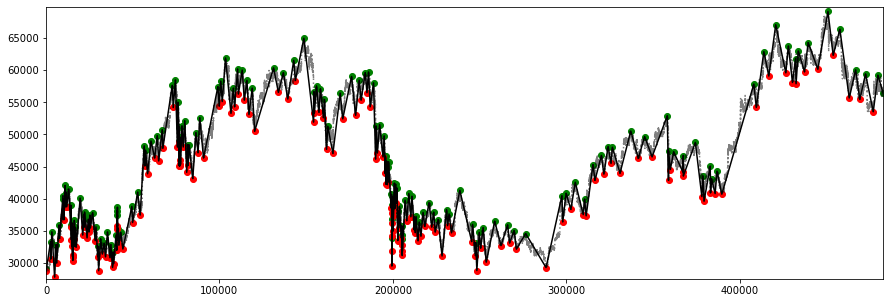

In [21]:
plot_pivots(data_train.close, zz_pivots)

In [22]:
zz_y = -zz_pivots.replace(0, np.nan).fillna(method='ffill')

In [23]:
zz_res = SignalStrategy(zz_y, shift=1).run(data_train)
zz_res.summary()

Net profit:        1306505.00     Gross profit:      1306505.00
Raw profit:        1306505.00     Gross loss:              0.00
Fee paid:                0.00     Max drawdown:         2898.00
Trades count:             307     Profit factor:            inf
Profitable:           100.00%     Recovery factor:       450.83
Losing:                 0.00%     Sharpe ratio:          603.62
PPT %:                  9.80%     My ratio:                8.69


In [16]:
%%time
ma_cross_res = MACrossStrategy().run(data_train)
ma_cross_res.summary()

Net profit:         -13627.50     Gross profit:      1166661.00
Raw profit:         -13627.50     Gross loss:       -1180288.50
Fee paid:                0.00     Max drawdown:        57012.50
Trades count:           21450     Profit factor:           0.99
Profitable:            36.20%     Recovery factor:        -0.24
Losing:                63.80%     Sharpe ratio:          -73.73
PPT %:                 -0.00%     My ratio:               -0.09
CPU times: user 14.2 s, sys: 578 ms, total: 14.8 s
Wall time: 14.8 s


<AxesSubplot:xlabel='time', ylabel='pnl'>

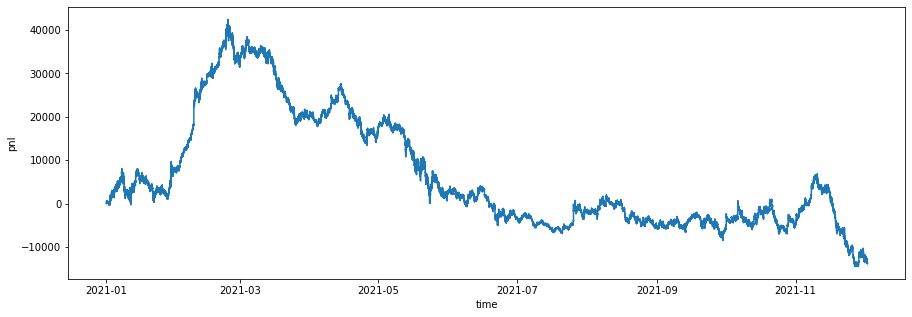

In [17]:
sns.lineplot(y=ma_cross_res.equity.pnl, x=data_train.time)

<AxesSubplot:xlabel='time', ylabel='pnl_open'>

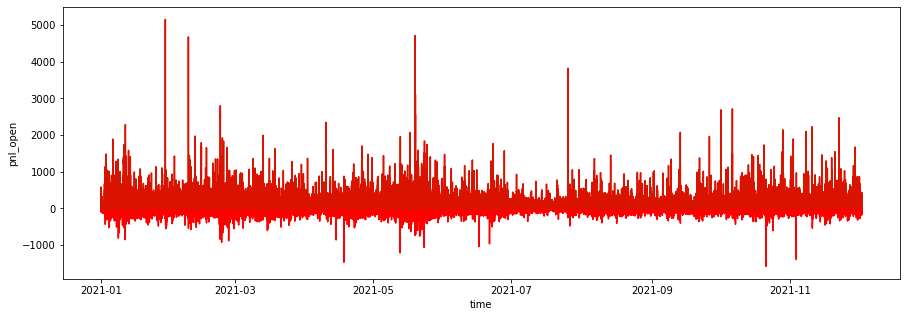

In [18]:
sns.lineplot(y=ma_cross_res.equity.pnl_open, x=data_train.time, color='r')
sns.lineplot(y=ma_cross_res.equity.pnl_open_max, x=data_train.time, color='g', alpha=0.15)

In [19]:
trades = ma_cross_res.trades
equity = ma_cross_res.equity
fix_pos = ma_cross_res.best_pos(min_bars_held=2)

In [20]:
trades

,pos,price_enter,price_exit,index_enter,index_exit,index_max,index_min,fee,pnl,pnl_max,pnl_min,result
0,1,28870.0,29359.0,24,84,74,29,0.0,489.0,585.0,-3.0,489.0
1,1,29425.0,29439.5,89,104,98,93,0.0,14.5,115.0,-25.0,14.5
2,1,29420.0,29420.0,114,115,114,114,0.0,0.0,0.0,0.0,0.0
3,1,29450.0,29421.5,118,127,120,126,0.0,-28.5,60.0,-28.0,-28.5
4,1,29390.0,29284.5,143,151,144,150,0.0,-105.5,26.5,-105.5,-105.5
...,...,...,...,...,...,...,...,...,...,...,...,...
21445,1,57230.0,57056.0,482557,482566,482558,482565,0.0,-174.0,117.0,-174.5,-174.0
21446,1,56644.0,56477.0,482585,482589,482585,482588,0.0,-167.0,58.5,-174.5,-167.0
21447,1,56389.5,56346.0,482604,482629,482623,482608,0.0,-43.5,356.5,-79.0,-43.5
21448,1,56245.0,56152.5,482657,482661,482657,482659,0.0,-92.5,45.5,-93.0,-92.5


In [21]:
%%time
mac_fix_res = SignalStrategy(fix_pos).run(data_train)
mac_fix_res.summary()

Net profit:        2272721.00     Gross profit:      2272854.50
Raw profit:        2272721.00     Gross loss:           -133.50
Fee paid:                0.00     Max drawdown:         1044.00
Trades count:           11365     Profit factor:       17025.13
Profitable:            99.67%     Recovery factor:      2176.94
Losing:                 0.33%     Sharpe ratio:         9403.11
PPT %:                  0.42%     My ratio:                8.29
CPU times: user 12.5 s, sys: 553 ms, total: 13.1 s
Wall time: 13.1 s


In [22]:
mac_fix_res.trades

,pos,price_enter,price_exit,index_enter,index_exit,index_max,index_min,fee,pnl,pnl_max,pnl_min,result
0,1,28870.0,29454.5,24,75,74,29,0.0,584.5,585.0,-3.0,584.5
1,1,29425.0,29540.0,89,99,98,93,0.0,115.0,115.0,-25.0,115.0
2,1,29450.0,29511.0,118,121,120,118,0.0,61.0,60.0,0.0,61.0
3,1,29336.5,29400.0,165,170,169,165,0.0,63.5,63.0,0.0,63.5
4,1,29318.0,29359.5,185,196,195,188,0.0,41.5,41.5,-28.0,41.5
...,...,...,...,...,...,...,...,...,...,...,...,...
11360,1,56447.5,56513.5,482492,482496,482495,482492,0.0,66.0,63.5,0.0,66.0
11361,1,56631.5,56745.0,482507,482510,482509,482507,0.0,113.5,113.0,0.0,113.5
11362,1,56755.0,57181.5,482532,482548,482547,482532,0.0,426.5,439.5,-0.5,426.5
11363,1,56389.5,56746.5,482604,482624,482623,482608,0.0,357.0,356.5,-79.0,357.0


### Подход №1
пробуем обучить модель покупать-продавать в идеальных точках

`MACrossStrategy` входит в позицию на баре, следующем после пересечения средних - это непременное условие отсутствия "подглядывания в будущее". Кроме того, метод `best_pos` делает выход из позиции на баре, следующим за баром с максимальным доходом по текущей позиции - по той же причине. Поэтому для обучения модели целесобразно сдвинуть ряд `fix_pos` на 1 в прошлое

In [23]:
target = fix_pos.shift(-1).fillna(0).astype('int')
target.name = 'target'

In [24]:
temp = pd.concat([data_train.drop(columns='time'), target], axis=1)
X, y = df2xy(temp.dropna(), target_col='target', steps_in_rows=False)
X.shape, y.shape

((482659, 1, 134), (482659,))

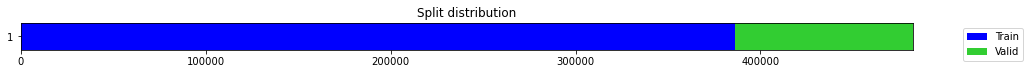

((#386128) [0,1,2,3,4,5,6,7,8,9...],
 (#96531) [386128,386129,386130,386131,386132,386133,386134,386135,386136,386137...])

In [26]:
splits = get_splits(y, valid_size=.2, stratify=True, random_state=RANDOM_SEED, shuffle=False)
splits

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.571365,0.562128,0.757071,11:53
1,0.468074,0.444496,0.868984,12:12
2,0.377114,0.363018,0.886291,12:01
3,0.363389,0.349763,0.889938,11:59
4,0.378166,0.352578,0.889351,12:01
5,0.359882,0.353365,0.884640,12:02
6,0.343279,0.346956,0.890177,12:03
7,0.351576,0.343294,0.893624,12:07
8,0.343510,0.336792,0.896651,12:03
9,0.344031,0.336177,0.896954,12:06


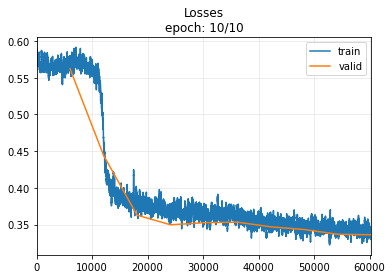

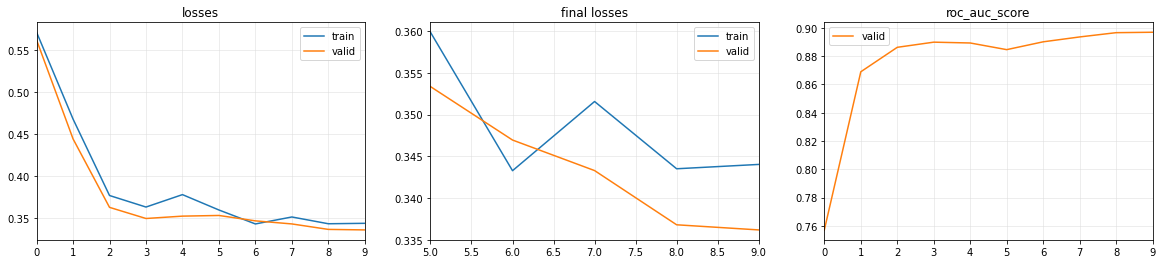

CPU times: user 6h 23min 56s, sys: 21 s, total: 6h 24min 17s
Wall time: 2h 48s


In [27]:
%%time
batch_tfms = TSStandardize()
clf = TSClassifier(X, y, splits=splits, arch=TST, batch_tfms=batch_tfms, metrics=RocAucBinary(), cbs=ShowGraph())
clf.fit_one_cycle(10, 3e-4)
clf.export("save/clf.pkl") # make sure you set the path to a folder that already exists

In [41]:
def validate_strategy(strategy, X_val, y_val, predictor, shift=1):
    print('Original strategy on validation data:')
    res_orig = strategy.run(X_val)
    res_orig.summary()
    print()
    print('Ideal footprint (y_val):')
    res_val = SignalStrategy(y_val, shift=shift).run(X_val)
    res_val.summary()
    print()
    print('Prediction footprint:')
    res_pred = SignalStrategy(predictor, shift=shift).run(X_val)
    res_pred.summary()
    
    return (res_orig, res_val, res_pred)

In [28]:
data_test = df_mac.drop(columns='time').iloc[TRAIN_SIZE:]

In [29]:
X_test, _ = df2xy(data_test, steps_in_rows=False)
X_test.shape

(85180, 1, 134)

In [30]:
test_probas, test_targets, test_preds = clf.get_X_preds(X_test, with_decoded=True)

In [31]:
test_probas.T[1][:10]

TensorBase([0.5546, 0.2730, 0.5096, 0.4944, 0.4720, 0.5329, 0.0943, 0.6000, 0.6850,
        0.3023])

In [32]:
test_preds[:10]

array(['1', '0', '1', '0', '0', '1', '0', '1', '1', '0'], dtype='<U1')

In [33]:
y_test_pred = pd.Series(data=test_preds, index=data_test.index).astype('int')

In [34]:
y_test_pred.value_counts()

0    62936
1    22244
dtype: int64

In [35]:
mac_test_res = MACrossStrategy().run(data_test)
mac_test_res.summary()

Net profit:           2371.50     Gross profit:       150447.50
Raw profit:           2371.50     Gross loss:        -148076.00
Fee paid:                0.00     Max drawdown:        11516.50
Trades count:            3649     Profit factor:           1.02
Profitable:            37.35%     Recovery factor:         0.21
Losing:                62.65%     Sharpe ratio:           18.15
PPT %:                  0.00%     My ratio:                0.03


In [36]:
y_test_dirty = mac_test_res.equity.pos.shift(-1).fillna(0)
y_test = mac_test_res.best_pos().shift(-1).fillna(0).astype('int') # again shift

In [37]:
def print_metrics(y0, y1):
    acc = accuracy_score(y0, y1)
    prc = precision_score(y0, y1)
    f1s = f1_score(y0, y1)
    roc = roc_auc_score(y0, y1)
    print(f'Accuracy: {acc:.4f}; Precision: {prc:.4f}; F1: {f1s:.4f}; ROC AUC: {roc:.4f}')

In [38]:
print_metrics(y_test, y_test_pred)

Accuracy: 0.8270; Precision: 0.6972; F1: 0.6780; ROC AUC: 0.7753


In [39]:
mac_test_sig_res2 = SignalStrategy(y_test_pred, shift=1).run(data_test)
mac_test_sig_res2.summary()

Net profit:          13150.00     Gross profit:       144611.50
Raw profit:          13150.00     Gross loss:        -131461.50
Fee paid:                0.00     Max drawdown:         3797.00
Trades count:            6141     Profit factor:           1.10
Profitable:            33.85%     Recovery factor:         3.46
Losing:                66.15%     Sharpe ratio:          167.70
PPT %:                  0.00%     My ratio:                0.59


In [40]:
def confirm_pred(y0, y1=None, weights=None, threshold=0.5):
    y1_ = y1 if not y1 is None else y0.shift(1).fillna(0)
    w_ = weights if not weights is None else [0.5, 0.5]
    res = (((y0 * w_[0]) + (y1_ * w_[1])) > threshold)
    return res.astype('int') if isinstance(res, pd.Series) else int(res)

In [41]:
# y_test_proba = pd.Series(data=test_probas.T[1], index=data_test.index)

In [42]:
y_test_conf = confirm_pred(y_test_proba, y1=y_test_dirty)

NameError: name 'y_test_proba' is not defined

In [ ]:
print_metrics(y_test, y_test_conf)

In [43]:
mac_test_sig_res3 = SignalStrategy(y_test_conf, shift=1).run(data_test)
mac_test_sig_res3.summary()

NameError: name 'y_test_conf' is not defined